<a href="https://colab.research.google.com/github/AKBER-HUSSAIN/ML_Lab_Practice/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this exercise, you will experiment with regression, regularization, and cross-validation. Choose
appropriate Dataset.


(a) Load the data into memory. Make an appropriate X matrix and y vector.

(b) Split the data at random into one set (Xtrain, ytrain) containing 80% of the instances, which will
be used for training + validation, and a testing set Xtest, ytest (containing remaining instances).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/dataset/diabetes.csv")

# Columns where 0 means missing
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace 0 with NaN
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# Fill NaN with median values
imputer = SimpleImputer(strategy="median")
df[cols_with_zeros] = imputer.fit_transform(df[cols_with_zeros])

# Split into features & target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


(c) Give the objective of logistic regression with L2 regularization.

Ridge regression, also known as L2 regularization, is a technique used in linear regression to prevent overfitting by adding a penalty term to the loss function. This penalty is proportional to the square of the magnitude of the coefficients (weights).

Ridge Regression is a version of linear regression that includes a penalty to prevent the model from overfitting, especially when there are many predictors or not enough data.

The standard loss function (mean squared error) is modified to include a regularization term:


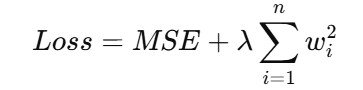


Here, 𝜆 λ is the regularization parameter that controls the strength of the penalty, and wi are the coefficients.

Encouraging the model's coefficients to be small but not exactly zero.
It helps to prevent any one feature from having an overly dominant effect on the predictions.
The larger the ' λ ' value, the stronger the regularization, and the smaller the coefficients will become

(d) Run logistic regression on the data using L2 regularization, varying the regularization parameter
λ ∈ {0, 0.1, 1, 10, 100, 1000}. Plot on one graph the average cross-entropy for the training data
and the testing data (averaged over all instances), as a function of λ (you should use a log scale
for λ). Plot on another graph the L2 norm of the weight vector you obtain. Plot on the third
graph the actual values of the weights obtained (one curve per weight). Finally, plot on a
graph the accuracy on the training and test set. Explain briefly what you see.

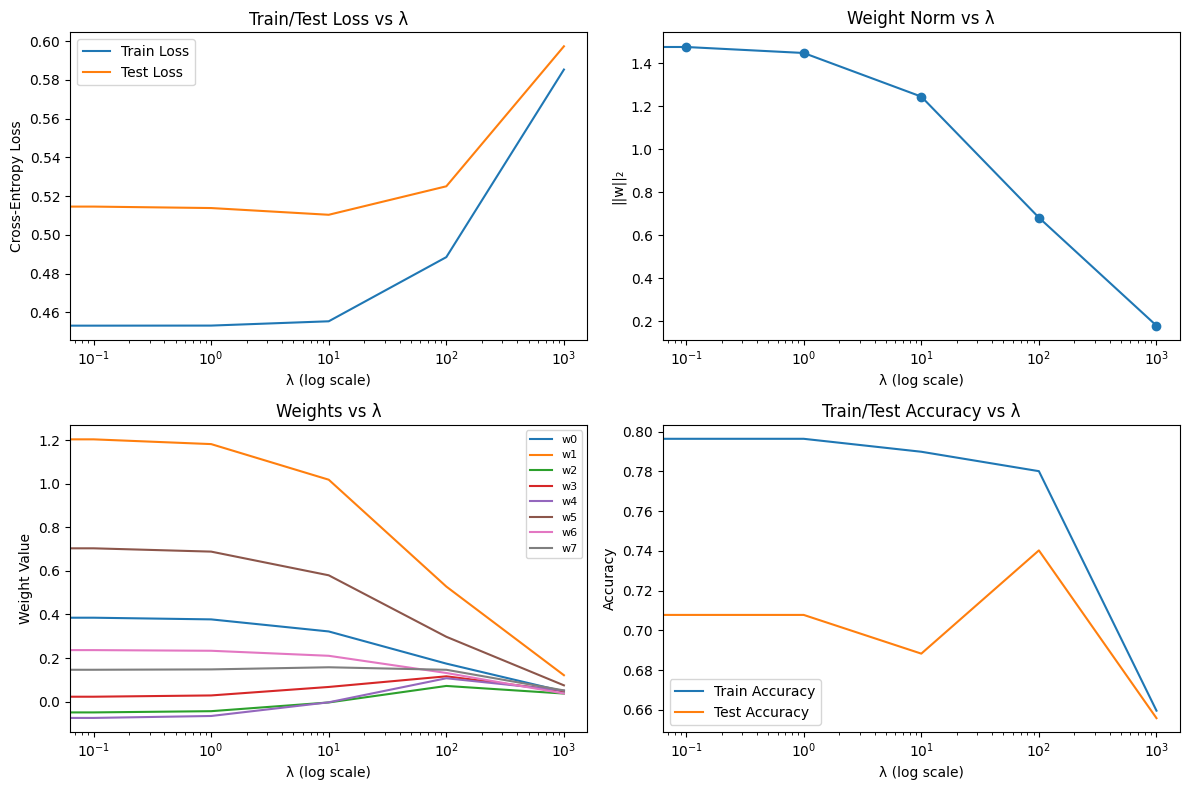

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

# λ values (regularization strength)
lambdas = [0, 0.1, 1, 10, 100, 1000]

train_losses = []
test_losses = []
train_acc = []
test_acc = []
weight_norms = []
weights_list = []

for lam in lambdas:
    # In sklearn, C = 1 / λ  (set C very large for λ=0)
    C = 1e12 if lam == 0 else 1 / lam

    model = LogisticRegression(
        penalty="l2", C=C, solver="lbfgs", max_iter=500
    )
    model.fit(X_train, y_train)

    # Predictions
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Cross-entropy loss
    train_losses.append(log_loss(y_train, y_train_prob))
    test_losses.append(log_loss(y_test, y_test_prob))

    # Accuracy
    train_acc.append(accuracy_score(y_train, model.predict(X_train)))
    test_acc.append(accuracy_score(y_test, model.predict(X_test)))

    # Store weight info
    weight_vector = model.coef_[0]
    weight_norms.append(np.linalg.norm(weight_vector))
    weights_list.append(weight_vector)

# ---- PLOTS ----
plt.figure(figsize=(12, 8))

# Plot 1: Training vs Testing Loss
plt.subplot(2, 2, 1)
plt.semilogx(lambdas, train_losses, label="Train Loss")
plt.semilogx(lambdas, test_losses, label="Test Loss")
plt.xlabel("λ (log scale)")
plt.ylabel("Cross-Entropy Loss")
plt.title("Train/Test Loss vs λ")
plt.legend()

# Plot 2: Weight Norm
plt.subplot(2, 2, 2)
plt.semilogx(lambdas, weight_norms, marker='o')
plt.xlabel("λ (log scale)")
plt.ylabel("||w||₂")
plt.title("Weight Norm vs λ")

# Plot 3: Weight values
plt.subplot(2, 2, 3)
weights_array = np.array(weights_list)
for i in range(weights_array.shape[1]):
    plt.semilogx(lambdas, weights_array[:, i], label=f"w{i}")
plt.xlabel("λ (log scale)")
plt.ylabel("Weight Value")
plt.title("Weights vs λ")
plt.legend(fontsize=8)

# Plot 4: Accuracy
plt.subplot(2, 2, 4)
plt.semilogx(lambdas, train_acc, label="Train Accuracy")
plt.semilogx(lambdas, test_acc, label="Test Accuracy")
plt.xlabel("λ (log scale)")
plt.ylabel("Accuracy")
plt.title("Train/Test Accuracy vs λ")
plt.legend()

plt.tight_layout()
plt.show()


As λ increases, the model’s weights get smaller, which makes the model simpler. This reduces overfitting but can also make the model underfit if λ is too large. We see that for very high λ, the loss increases and accuracy drops. In short — small λ gives better accuracy, but too much regularization hurts performance.

(e)Re-format the data in the following way: take each of the input variables, and feed it through
a set of Gaussian basis functions, defined as follows. For each variable (except the bias term),
use 5 univariate basis functions with means evenly spaced between -10 and 10 and variance σ.
You will experiment with σ values of 0.1, 0.5, 1, 5 and 10.

In [ ]:
def gaussian_basis(X, num_bases=5, sigma=1.0, feature_range=(-10, 10)):
    n_samples, n_features = X.shape
    means = np.linspace(feature_range[0], feature_range[1], num_bases)

    X_transformed = []

    for i in range(n_features):
        for mu in means:
            phi = np.exp(-(X[:, i] - mu) ** 2 / (2 * sigma ** 2))
            X_transformed.append(phi)

    return np.column_stack(X_transformed)

sigma_values = [0.1, 0.5, 1, 5, 10]

X_train_gaussian = {}
X_test_gaussian = {}

print("Original X_train shape:", X_train.shape)
print("-" * 60)

for sigma in sigma_values:
    X_train_gauss = gaussian_basis(X_train, num_bases=5, sigma=sigma)
    X_test_gauss  = gaussian_basis(X_test, num_bases=5, sigma=sigma)

    X_train_gaussian[sigma] = X_train_gauss
    X_test_gaussian[sigma]  = X_test_gauss

    print(f"Sigma = {sigma}")
    print("Transformed X_train shape:", X_train_gauss.shape)
    print("Transformed X_test  shape:", X_test_gauss.shape)
    print("-" * 60)


Original X_train shape: (614, 8)
------------------------------------------------------------
Sigma = 0.1
Transformed X_train shape: (614, 40)
Transformed X_test  shape: (154, 40)
------------------------------------------------------------
Sigma = 0.5
Transformed X_train shape: (614, 40)
Transformed X_test  shape: (154, 40)
------------------------------------------------------------
Sigma = 1
Transformed X_train shape: (614, 40)
Transformed X_test  shape: (154, 40)
------------------------------------------------------------
Sigma = 5
Transformed X_train shape: (614, 40)
Transformed X_test  shape: (154, 40)
------------------------------------------------------------
Sigma = 10
Transformed X_train shape: (614, 40)
Transformed X_test  shape: (154, 40)
------------------------------------------------------------


(f)Using no regularization and doing regression with this new set of basis functions, plot the
training and testing error as a function of σ (when using only basis functions of a given σ). Add
constant lines showing the training and testing error you had obtained in part c. Explain how σ
influences overfitting and the bias-variance trade-off.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


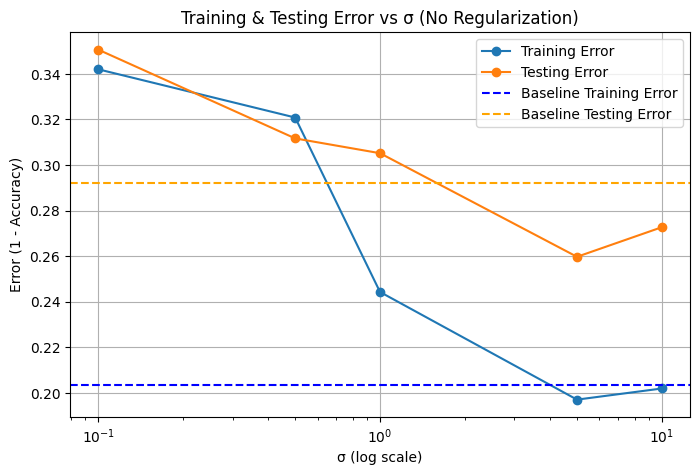

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

baseline_model = LogisticRegression(penalty=None, max_iter=500, solver='lbfgs')
baseline_model.fit(X_train, y_train)
baseline_train_acc = accuracy_score(y_train, baseline_model.predict(X_train))
baseline_test_acc  = accuracy_score(y_test,  baseline_model.predict(X_test))

baseline_train_error = 1 - baseline_train_acc
baseline_test_error  = 1 - baseline_test_acc

train_errors = []
test_errors = []

for sigma in sigma_values:
    X_train_gauss = X_train_gaussian[sigma]
    X_test_gauss  = X_test_gaussian[sigma]

    model = LogisticRegression(penalty=None, max_iter=500, solver='lbfgs')
    model.fit(X_train_gauss, y_train)

    y_train_pred = model.predict(X_train_gauss)
    y_test_pred  = model.predict(X_test_gauss)

    train_errors.append(1 - accuracy_score(y_train, y_train_pred))
    test_errors.append(1 - accuracy_score(y_test,  y_test_pred))

plt.figure(figsize=(8, 5))
plt.plot(sigma_values, train_errors, marker='o', label='Training Error')
plt.plot(sigma_values, test_errors, marker='o', label='Testing Error')

plt.axhline(baseline_train_error, color='blue', linestyle='--', label='Baseline Training Error')
plt.axhline(baseline_test_error,  color='orange', linestyle='--', label='Baseline Testing Error')

plt.xscale('log')
plt.xlabel("σ (log scale)")
plt.ylabel("Error (1 - Accuracy)")
plt.title("Training & Testing Error vs σ (No Regularization)")
plt.legend()
plt.grid()
plt.show()


(g)Add in all the basis function and perform regularized regression with the regularization
parameter λ ∈ {0, 0.1, 1, 10, 100, 1000, 10000}. Plot on one graph the average cross- entropy
error for the training data and the testing data, as a function of λ (you should use a log scale
for λ). Plot on another graph the L2 norm of the weight vector you obtain. Plot on a different
graph the L2 norm of the weights for the set of basis functions corresponding to each value
of σ, as a function of λ (this will be a graph with 5 lines on it). Explain briefly the results.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


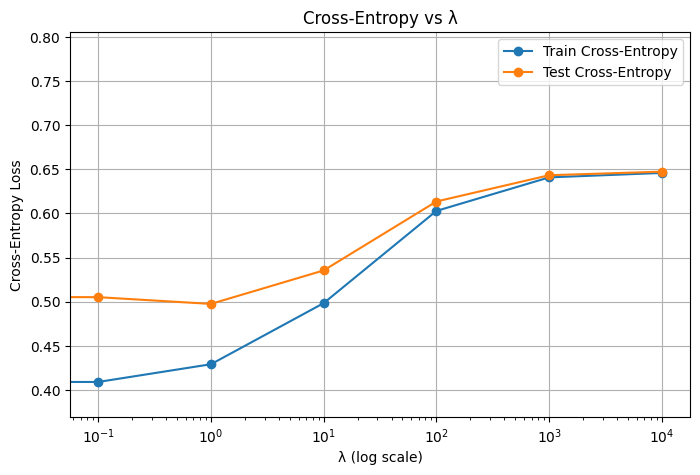

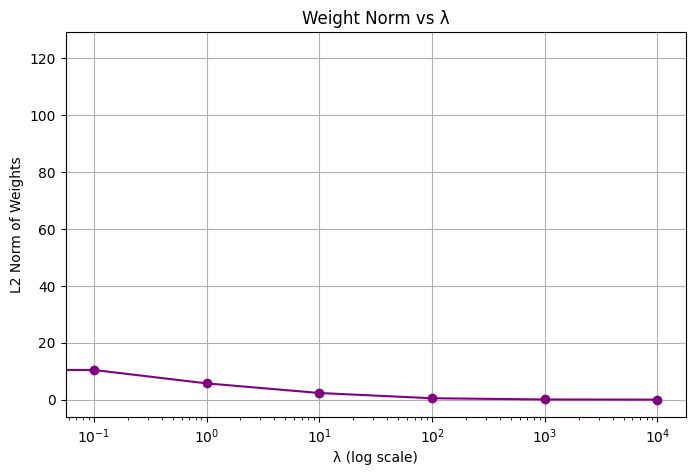

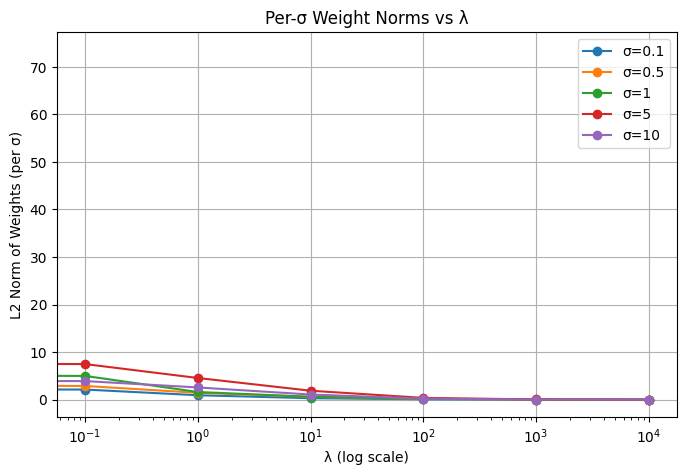

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Step 1: Combine all Gaussian basis features into one big matrix
X_train_all = np.hstack([X_train_gaussian[sigma] for sigma in sigma_values])
X_test_all  = np.hstack([X_test_gaussian[sigma]  for sigma in sigma_values])

lambda_values = [0, 0.1, 1, 10, 100, 1000, 10000]

train_cross_entropy = []
test_cross_entropy = []
weight_norms = []

# For per-σ weight norms
per_sigma_weight_norms = {sigma: [] for sigma in sigma_values}
feature_splits = [X_train_gaussian[sigma].shape[1] for sigma in sigma_values]

for lam in lambda_values:
    if lam == 0:
        model = LogisticRegression(penalty=None, max_iter=500, solver='lbfgs')
    else:
        model = LogisticRegression(penalty='l2', C=1/lam, max_iter=500, solver='lbfgs')

    model.fit(X_train_all, y_train)

    # Predictions (probabilities for cross-entropy)
    y_train_prob = model.predict_proba(X_train_all)
    y_test_prob  = model.predict_proba(X_test_all)

    # Step 2: Cross-entropy loss
    train_cross_entropy.append(log_loss(y_train, y_train_prob))
    test_cross_entropy.append(log_loss(y_test, y_test_prob))

    # Step 3: Weight norms
    w = model.coef_.flatten()
    weight_norms.append(np.linalg.norm(w))

    # Step 4: Per-σ weight norms
    start = 0
    for sigma, n_features in zip(sigma_values, feature_splits):
        end = start + n_features
        per_sigma_weight_norms[sigma].append(np.linalg.norm(w[start:end]))
        start = end

# Step 5: Plot 1 - Cross-Entropy vs λ
plt.figure(figsize=(8, 5))
plt.plot(lambda_values, train_cross_entropy, marker='o', label='Train Cross-Entropy')
plt.plot(lambda_values, test_cross_entropy, marker='o', label='Test Cross-Entropy')
plt.xscale('log')
plt.xlabel("λ (log scale)")
plt.ylabel("Cross-Entropy Loss")
plt.title("Cross-Entropy vs λ")
plt.legend()
plt.grid()
plt.show()

# Step 6: Plot 2 - Total Weight Norm vs λ
plt.figure(figsize=(8, 5))
plt.plot(lambda_values, weight_norms, marker='o', color='purple')
plt.xscale('log')
plt.xlabel("λ (log scale)")
plt.ylabel("L2 Norm of Weights")
plt.title("Weight Norm vs λ")
plt.grid()
plt.show()

# Step 7: Plot 3 - Per-σ Weight Norm vs λ
plt.figure(figsize=(8, 5))
for sigma in sigma_values:
    plt.plot(lambda_values, per_sigma_weight_norms[sigma], marker='o', label=f"σ={sigma}")

plt.xscale('log')
plt.xlabel("λ (log scale)")
plt.ylabel("L2 Norm of Weights (per σ)")
plt.title("Per-σ Weight Norms vs λ")
plt.legend()
plt.grid()
plt.show()


With increasing λ, training error rises while test error first decreases (reducing overfitting) and then increases (underfitting). The L2 norm of weights shrinks as λ grows, showing that regularization keeps weights small. For different σ values, small-σ basis functions are penalized more under strong regularization, leading the model to prefer smoother, large-σ features.

(h)Explain what you would need to do if you wanted to design a set of Gaussian basis functions
that capture relationships between the inputs. Explain the impact of this choice on 2 the bias-variance trade-off. No experiments are needed (although you are welcome to explore
this on your own).

To capture relationships between inputs, we would use multivariate Gaussian basis functions instead of univariate ones. This means creating basis functions that depend on combinations of input features (e.g., 𝑥1,𝑥2x1,x2) instead of treating each feature independently. The means would be points in the multi-dimensional input space, and the covariance matrices would determine the spread and orientation of each Gaussian.

Impact on bias-variance trade-off:
This approach reduces bias because the model becomes more expressive and can capture interactions between features. However, it also increases variance since the number of parameters grows quickly, making the model more sensitive to noise and prone to overfitting. Regularization or more data would be needed to control this higher variance.

(i)Suppose that instead of wanting to use a fixed set of evenly-spaced basis functions, you would
like to adapt the placement of these functions. Derive a learning algorithm that computes
both the placement of the basis function, μi and the weight vector w from data (assuming
that the width σ isfixed. You should still allow for L2 regularization of the weight vector.
Note that your algorithm will need to be iterative.

In order to adapt the placement of Gaussian basis functions, we can use an iterative learning algorithm that jointly optimizes the centers (μᵢ) and the weights (w). First, we initialize μᵢ randomly (or using k-means) and compute the design matrix Φ using Gaussian basis functions with fixed σ. Then, we solve for w using ridge regression (closed-form solution with L2 regularization). Next, we update μᵢ using gradient descent, moving the centers toward regions where the prediction error is high. This process is repeated until convergence or until the cost function stops improving. This adaptive approach places basis functions where they best represent the data, improving flexibility but increasing variance, so regularization is essential.

(j) Does your algorithm converge? If so, does it obtain a locally or globally optimal solution?
Explain your answer.

Yes, the algorithm converges because both weight updates (w) and center updates (μᵢ) iteratively minimize the regularized cost function. However, since the optimization over μᵢ is non-convex, the algorithm generally converges to a locally optimal solution, not a globally optimal one. The final solution depends on the initialization of μᵢ, and different initializations may lead to different local minima. Regularization helps improve stability and prevents overfitting, but it does not guarantee a unique global optimum.

**2. Experiment on any complex datasets to demonstrate the Linear REGRESSION and its versions, and
logistic regression (CLASSIFICATION) along with complete data preprocessing steps.**

# **Linear Regression**

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


housing = pd.read_csv("/content/drive/MyDrive/dataset/Housing.csv")

print("Housing Dataset Shape:", housing.shape)
print(housing.head())


X_housing = housing.drop("price", axis=1)
y_housing = housing["price"]


scaler = StandardScaler()
X_housing_scaled = scaler.fit_transform(X_housing)


Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    X_housing_scaled, y_housing, test_size=0.2, random_state=42
)

lin_reg = LinearRegression()
lin_reg.fit(Xh_train, yh_train)

yh_pred_train = lin_reg.predict(Xh_train)
yh_pred_test = lin_reg.predict(Xh_test)


print("\nLINEAR REGRESSION RESULTS")
print(f"Training RMSE: {mean_squared_error(yh_train, yh_pred_train, squared=False):.2f}")
print(f"Testing RMSE : {mean_squared_error(yh_test, yh_pred_test, squared=False):.2f}")
print(f"R² Score (Train): {r2_score(yh_train, yh_pred_train):.4f}")
print(f"R² Score (Test) : {r2_score(yh_test, yh_pred_test):.4f}")


ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.1)
ridge.fit(Xh_train, yh_train)
lasso.fit(Xh_train, yh_train)

print("\nRIDGE REGRESSION R²:", ridge.score(Xh_test, yh_test))
print("LASSO REGRESSION R²:", lasso.score(Xh_test, yh_test))


# **Logistic Regression**

In [4]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


df = pd.read_csv("/content/drive/MyDrive/dataset/breast-cancer.csv")  # Change path if needed

label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])


X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


model = LogisticRegression(max_iter=500, solver='lbfgs')
model.fit(X_train, y_train)


y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


print("\nMODEL EVALUATION")
print(f"Training Accuracy : {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Testing Accuracy  : {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision         : {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall            : {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score          : {f1_score(y_test, y_pred_test):.4f}")

print("\nCLASSIFICATION REPORT:\n", classification_report(y_test, y_pred_test, target_names=['Benign', 'Malignant']))



MODEL EVALUATION
Training Accuracy : 0.9868
Testing Accuracy  : 0.9649
Precision         : 0.9750
Recall            : 0.9286
F1-Score          : 0.9512

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

      Benign       0.96      0.99      0.97        72
   Malignant       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

